In [1]:
from qpe import *

from time import time


from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [20]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)

    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u
    
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    # for j in range(len(labels)): # take a density matrix from the training set
    #     print(j, end="\r")
    #     probs = [trace(dms_cop[j]@proj).real for proj in projs_u]
    #     expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
    #     disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
    #     expecs.append(expec)
    #     disps.append(disp)
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

### Settings

In [3]:
n_inp = 2
n_train = 1000
n_test = 10000
mixed = False
marks = "neg"

dms_train, labels_train_lin = gen_even_ent_data(n_train, n_inp=n_inp, mixed=mixed, marks=marks)
dms_test, labels_test_lin = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)

w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e3)}#, "maxfun": int(1e10)}#

In [4]:
save_path = r"/home/kardashin/Work/QPE/Results/Entanglement/Squared negativity/"
file_info = "T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_train, w_ls, w_var, marks, mixed)

In [5]:
labels_train_sq = array(labels_train_lin)**2
labels_test_sq = array(labels_test_lin)**2

In [6]:
# np.save(save_path + file_info + "-labels_train_lin", labels_train_lin)
# np.save(save_path + file_info + "-dms_train", dms_train)

#### Run

In [14]:
n_copies = 2
n_layers = 2
n_tot = n_inp*n_copies
n_meas = n_inp*n_copies

x0 = concatenate([normal(pi/4, 0.1, (3*n_tot - 1)*n_layers + 2*n_tot), normal(0, 1e-2, 2**n_meas)])

file_name = save_path + "c=%d-m=%d=l=%d-" %(n_copies, n_meas, n_layers) + file_info + "-pars"

In [15]:
time_start_lin = time()
fvals_lin, result_lin = train(dms_train, labels_train_lin, n_layers, 
                              n_copies=n_copies, n_meas=n_meas, x0=x0,
                              method=method, w_ls=w_ls, w_var=w_var, options=options)#, save_data=True, file_name=file_name)
time_finish_lin = time() - time_start_lin
print("\n\nFinished in", time_finish_lin)
print("Cost:", result_lin.fun)
print(result_lin.message)
pars_lin = result_lin.x

Iteration: 357 | Function value: 5.05063315

Finished in 260.53808879852295
Cost: 5.050633150887992
Optimization terminated successfully.


In [16]:
time_start_sq = time()
fvals_sq, result_sq = train(dms_train, labels_train_sq, n_layers, 
                            n_copies=n_copies, n_meas=n_meas, x0=x0,
                            method=method, w_ls=w_ls, w_var=w_var, options=options)#, save_data=True, file_name=file_name)
time_finish_sq = time() - time_start_sq
print("\n\nFinished in", time_finish_sq)
print("Cost:", result_sq.fun)
print(result_sq.message)
pars_sq = result_sq.x

Iteration: 172 | Function value: 0.11314655

Finished in 126.71159195899963
Cost: 0.11314654969396461
Optimization terminated successfully.


In [17]:
expecs_train_lin, disps_train_lin = aux_info(dms_train, labels_train_lin, n_layers, pars_lin, n_copies=n_copies, n_meas=n_meas)
expecs_test_lin, disps_test_lin = aux_info(dms_test, labels_test_lin, n_layers, pars_lin, n_copies=n_copies, n_meas=n_meas)

In [18]:
expecs_train_sq, disps_train_sq = aux_info(dms_train, labels_train_sq, n_layers, pars_sq, n_copies=n_copies, n_meas=n_meas)
expecs_test_sq, disps_test_sq = aux_info(dms_test, labels_test_sq, n_layers, pars_sq, n_copies=n_copies, n_meas=n_meas)

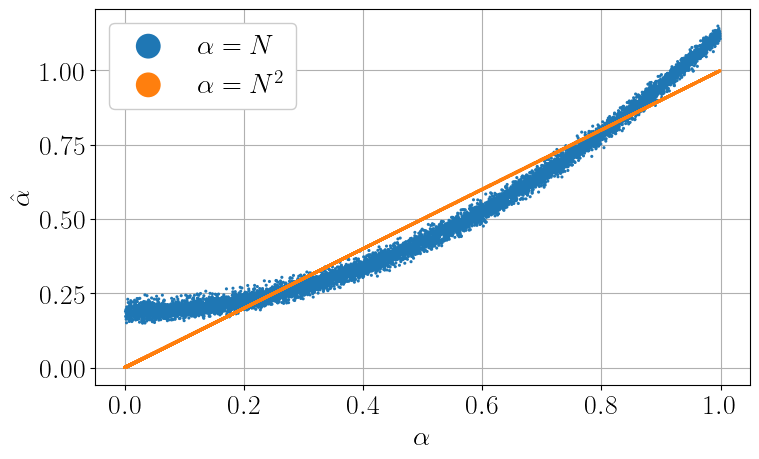

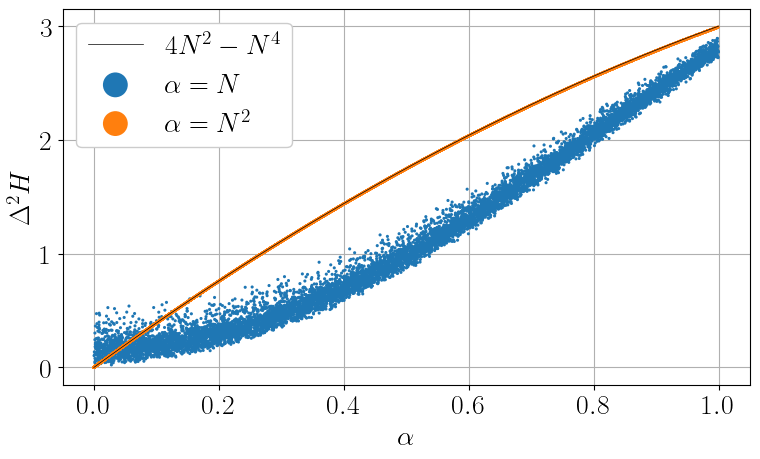

In [19]:
sv_singlet = array([0, 1, -1, 0])/sqrt(2)
dm_singlet = outer(sv_singlet, sv_singlet.conj().T)
H_theor = (4*kron(dm_singlet, eye(4)) + 4*kron(eye(4), dm_singlet))/2
H_theor_sq = H_theor@H_theor
disps_test_theor = array([trace(kron(dm, dm)@H_theor_sq).real for dm in dms_test])

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test_lin, expecs_test_lin, s=5, edgecolor='none', label=r"$\alpha=N$", color="tab:blue") # , color="dodgerblue"
plt.scatter(labels_test_sq, expecs_test_sq, s=5, edgecolor='none', label=r"$\alpha=N^2$", color="tab:orange") # , color="dodgerblue"
# plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
plt.grid()
plt.tight_layout()
plt.legend(framealpha=1, markerscale=8)
# plt.savefig(save_path + file_info + "-pure-lin_sq-preds-test.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.plot(linspace(0, 1)**2, [4*N**2 - N**4 for N in linspace(0, 1)], color="black", label=r"$4N^2 - N^4$", linewidth=0.5)
# plt.scatter(labels_test, disps_test_theor, s=2, edgecolor='none', label=r"$\alpha=N$", color="C3")
plt.scatter(labels_test_lin, disps_test_lin, s=5, edgecolor='none', label=r"$\alpha=N$")
plt.scatter(labels_test_sq, disps_test_sq, s=5, edgecolor='none', label=r"$\alpha=N^2$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\Delta^2 H$")
plt.grid()
plt.tight_layout()
plt.legend(framealpha=1, markerscale=8)
# plt.savefig(save_path + file_info + "-pure-lin_sq-vars-test.pdf", bbox_inches='tight')
plt.show()